# Task 1-2: Multi-pendulum system
This notebook is to visualize how ModLaNet performs when simulating triple or quadruple pendulum.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch, time, sys
import numpy as np
import scipy.integrate
solve_ivp = scipy.integrate.solve_ivp

EXPERIMENT_DIR = '../experiment-pend-2+'
sys.path.append(EXPERIMENT_DIR)

MODEL_DIR = '../src'
sys.path.append(MODEL_DIR)

from layers import MLP
from models import HNN, ModLaNet
from utils import L2_loss
from data import Dataset

In [2]:
plt.rcParams["font.family"] = "serif"
# plt.rcParams["font.serif"]  = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

In [3]:
wordsize = 18
plt.rc('font', size=wordsize)          # controls default text sizes
plt.rc('axes', titlesize=wordsize)     # fontsize of the axes title
plt.rc('axes', labelsize=wordsize)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=wordsize)    # fontsize of the tick labels
plt.rc('ytick', labelsize=wordsize)    # fontsize of the tick labels
plt.rc('legend', fontsize=wordsize)    # legend fontsize
plt.rc('figure', titlesize=wordsize)  # fontsize of the figure title

## Set some notebook constants

In [4]:
DPI = 300
FORMAT = 'png'
LINE_SEGMENTS = 10
ARROW_SCALE = 30 # 100 for pend-sim, 30 for pend-real
ARROW_WIDTH = 6e-3
LINE_WIDTH = 2
RK4 = ''

def get_args():
    return {'obj': 3,
            'dof': 1,
            'dim': 2,
            'hidden_dim': 200,
            'nonlinearity': 'tanh',
            'trans_hidden_dim': 16,
            'trans_nonlinearity': 'tanh',
            'energy_hidden_dim': 50,
            'energy_nonlinearity': 'identity',
            'learn_rate': 1e-3,
            'input_noise': 0.5,
            'total_steps': 12000,
            'field_type': 'solenoidal',
            'gridsize': 10,
            'verbose': True,
            'print_every': 100,
            'name': 'pend',
            'seed': 0,
            'save_dir': './{}'.format(EXPERIMENT_DIR+'/data'),
            'result_dir': '../results'}

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d
        
args = ObjectView(get_args())

## Construct models

In [5]:
def BuildComputationTree(transform = 'local', obj=2, dim=2, dof=1, device = 'cpu'):
    r"""
    User defined relations between elements and origins of local coordinate systems.
    We assume that these connections between origins and elements 
    can be obtained when local coordinate systems are constructed.

    Function: x_{i, origin} =   \sum_j x_{j, element} * weight_j + 
                                \sum_k x_{k, origin}  * weight_k + 
                                weight_c
    Form: [[i, 
            [[j1, weight_j1], [j2, weight_j2], ...], 
            [[k1, weight_k1], [k2, weight_k2], ...], 
            weight_c], ...]
    """
    tree = None
    if transform == 'local':
        ################################
        # User defined relations start #
        ################################
        ele  = [0, [], [], torch.zeros((dim), device = device)]
        tree = [ele]
        for i in range(1, obj):
            ele  = [i, [[i-1, 1.]], [], torch.zeros((dim), device = device)]
            tree.append(ele)
        ################################
        # User defined relations end   #
        ################################
    return tree

In [6]:
def get_model(args, model_name, end_epoch, noise, learn_rate, hidden_dim = None, load_obj = None):
    load_obj = args.obj if load_obj is None else load_obj
    hidden_dim = args.hidden_dim if hidden_dim is None else hidden_dim
    path = '{}/model-{}-{}-{}-hidden_dim-{}-end_epoch-{}-noise-{}-learn_rate-{}.tar'.format(args.save_dir, load_obj, args.name,
                                                                           model_name, hidden_dim, end_epoch,
                                                                           noise, learn_rate)
    checkpoint = torch.load(path)
    if model_name == 'modlanet':
        model = ModLaNet(obj=load_obj, dim=args.dim, edof=args.dof, build_computation_tree=BuildComputationTree, transform = 'local',
                         trans_hidden_dim = args.trans_hidden_dim, trans_nonlinearity = args.trans_nonlinearity, 
                         energy_hidden_dim = args.energy_hidden_dim)
        model.load_state_dict(checkpoint['network_state_dict'])
    else:
        assert load_obj == args.obj
        input_dim = args.obj * args.dof * 2
        output_dim = input_dim if model_name == 'baseline' else 2
        nn_model = MLP(input_dim, hidden_dim, output_dim, args.nonlinearity)
        model = HNN(input_dim, differentiable_model=nn_model,
                  field_type=args.field_type, baseline= (model_name == 'baseline') )

        model.load_state_dict(checkpoint['network_state_dict'])
    return model

In [7]:
def integrate_model(args, model, t_span, y0,  model_name = 'modlanet', **kwargs):
    if model_name == 'modlanet':
        def fun(t, np_x):
            x = torch.tensor( np_x[:args.obj*args.dof] % (2 * np.pi), requires_grad=True, dtype=torch.float32).view(1,args.obj*args.dof)
            v = torch.tensor( np_x[args.obj*args.dof:], requires_grad=True, dtype=torch.float32).view(1,args.obj*args.dof)
            dx = model.forward(x, v).data.numpy().reshape(-1)
            return np.concatenate((np_x[args.obj*args.dof:], dx))
    else:
        def fun(t, np_x):
            np_x[:args.obj*args.dof] = np_x[:args.obj*args.dof] % (2 * np.pi)
            x = torch.tensor( np_x, requires_grad=True, dtype=torch.float32).view(1,args.obj*args.dof*2)
            dx = model.time_derivative(x).data.numpy().reshape(-1)
            return dx
    return solve_ivp(fun=fun, t_span=t_span, y0=y0, **kwargs)

In [8]:
modlanet_model = get_model(args, model_name = 'modlanet', load_obj = 2, hidden_dim = 50, end_epoch = 10000, noise = 0., learn_rate = 0.01)
modlanet_model.update(obj = args.obj)

modlanet_model_retrain = get_model(args, model_name = 'modlanet', load_obj = 3, hidden_dim = 50, end_epoch = 12000, noise = 0., learn_rate = 0.01)
modlanet_model_retrain.update(obj = args.obj)


## Quantitative analysis

In [9]:
def polar2xy(x):
    pos = np.zeros([x.shape[0], x.shape[1]*2])
    for i in range(x.shape[1]):
        if i == 0:
            pos[:, 2*i:2*(i+1)] += np.concatenate([np.sin(x[:,i:i+1]), -np.cos(x[:,i:i+1])], 1)
        else:
            pos[:, 2*i:2*(i+1)] += pos[:, 2*(i-1):2*i] + np.concatenate([np.sin(x[:,i:i+1]), -np.cos(x[:,i:i+1])], 1)
    return pos

In [10]:
def polar2uv(x, v):
    vel = np.zeros([x.shape[0], x.shape[1]*2])
    for i in range(x.shape[1]):
        if i == 0:
            vel[:, 2*i:2*(i+1)] += np.concatenate([np.cos(x[:,i:i+1]) * v[:,i:i+1], np.sin(x[:,i:i+1]) * v[:,i:i+1]], 1)
        else:
            vel[:, 2*i:2*(i+1)] += vel[:, 2*(i-1):2*i] + np.concatenate([np.cos(x[:,i:i+1]) * v[:,i:i+1], np.sin(x[:,i:i+1]) * v[:,i:i+1]], 1)
    return vel

In [11]:
# np.random.seed(args.seed)
ds = Dataset(args.obj, m = [1 for i in range(args.obj)], l=[1 for i in range(args.obj)])

In [12]:
y0=np.array([i for i in range(args.obj)] + [0]*args.obj)
t_span = [0, 5]
timescale = 50
t_eval = np.linspace(t_span[0], t_span[1], (t_span[1]-t_span[0])*timescale+1)
kwargs = {'t_eval': t_eval, 'rtol': 1e-12}

truth_ivp = solve_ivp(fun=ds.dynamics_lagrangian_fn, t_span=t_span, y0=y0, **kwargs)
truth_pos = polar2xy(truth_ivp['y'][0:args.obj].T)
truth_vel = polar2uv(truth_ivp['y'][0:args.obj].T, truth_ivp['y'][args.obj:args.obj*2].T)

In [13]:
modlanet_ivp = integrate_model(args, modlanet_model_retrain, t_span, y0, model_name = 'modlanet', **kwargs)
modlanet_pos = polar2xy(modlanet_ivp['y'][0:args.obj].T)
modlanet_vel = polar2uv(modlanet_ivp['y'][0:args.obj].T, modlanet_ivp['y'][args.obj:args.obj*2].T)

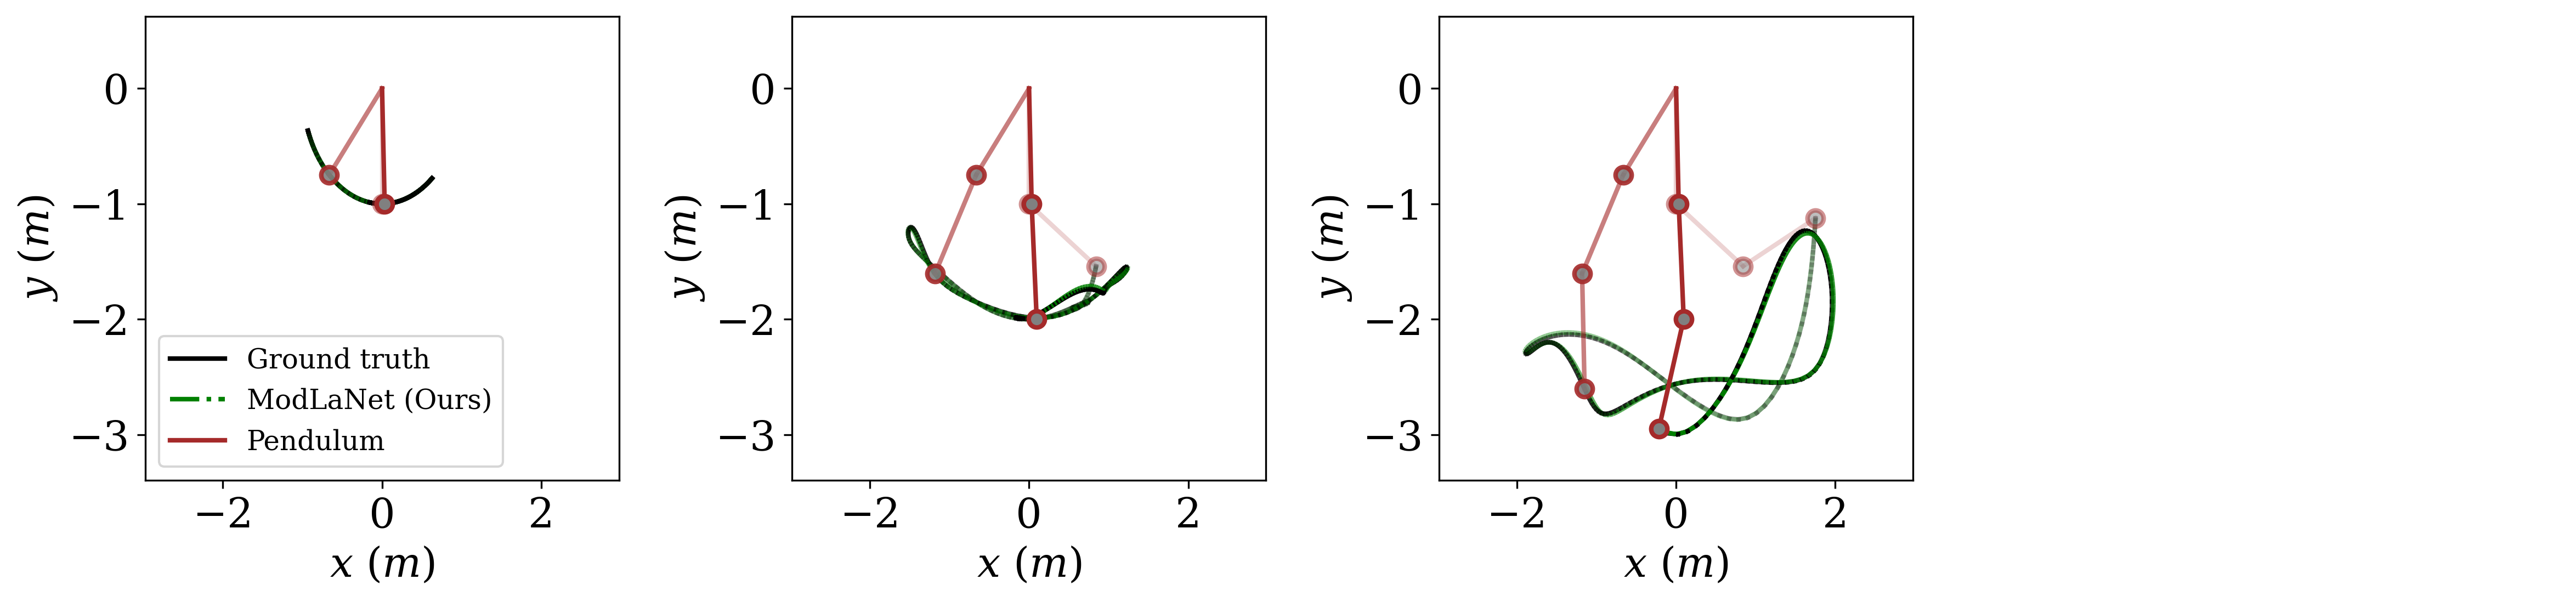

In [14]:
tpad = 4
fig = plt.figure(figsize=(4*tpad, 4), dpi=DPI)

time = min(200, len(truth_ivp['y'].T)-1)
objlist = [0, 1, 2, 3]
objlist.sort()
legendsize = 12
circlesize = 50
linewidth  = 2
margin = [0.4, 1, 1, 1]

max_id = 0
for k in range(tpad):
    if objlist[k]+1 <= args.obj:
        max_id = k
ylims = [9999, -9999]; xlims = [9999, -9999]
for k in range(max_id+1):
    ylims = [min(min(modlanet_pos[:,2*objlist[k]+1])-margin[0], ylims[0]), max(max(modlanet_pos[:,2*objlist[k]+1])+margin[1], ylims[1])]
    xlims = [min(min(modlanet_pos[:,2*objlist[k]])-margin[2], xlims[0]),   max(max(modlanet_pos[:,2*objlist[k]])+margin[3], xlims[1])]

for k in range(tpad):
    ax = plt.subplot(1, tpad, k+1)
    if objlist[k]+1 > args.obj:
        ax.axis('off')
    else:
        plt.xlabel('$x$ ($m$)') ; plt.ylabel('$y$ ($m$)')

        for i in range(time-2):
            # Plot the trajectory
            j = objlist[k]
            plt.plot(truth_pos[i:i+2,j*2],   truth_pos[i:i+2,j*2+1], 'k-', label='_nolegend_', linewidth=linewidth, alpha = 0.2 + 0.8 * (i+1)/time)
            plt.plot(modlanet_pos[i:i+2,j*2], modlanet_pos[i:i+2,j*2+1], 'g-.', label='_nolegend_', linewidth=linewidth, alpha = 0.2 + 0.8 * (i+1)/time)

            # Plot the pendulum
            if i % 100 == 0:
                j = 0
                plt.plot([0, truth_pos[i, j*2]], [0, truth_pos[i, 1+j*2]],  color = 'brown', linewidth = linewidth, label='_nolegend_', alpha = min(0.2 + 0.8 * (i+1)/time, 1),)
                plt.scatter(truth_pos[i, j*2], truth_pos[i, 1+j*2], s=circlesize, linewidths = linewidth, facecolors='gray', edgecolors='brown',  label='_nolegend_', alpha = min(0.5 + 0.8 * (i+1)/time, 1), zorder = 3)
                for j in range(1, objlist[k]+1):
                    plt.plot([truth_pos[i, (j-1)*2], truth_pos[i, j*2]], [truth_pos[i, (j-1)*2+1], truth_pos[i, 1+j*2]],  color = 'brown', linewidth = linewidth, label='_nolegend_', alpha = min(0.2 + 0.8 * (i+1)/time, 1),)
                    plt.scatter(truth_pos[i, j*2], truth_pos[i, 1+j*2], s=circlesize, linewidths = linewidth, facecolors='gray', edgecolors='brown',  label='_nolegend_', alpha = min(0.5 + 0.8 * (i+1)/time, 1), zorder = 3)

        # Plot the trajectory
        plt.plot(truth_pos[time-2:time,j*2],   truth_pos[time-2:time,1+j*2], 'k-', label='Ground truth', linewidth=linewidth, alpha = 1)
        plt.plot(modlanet_pos[time-2:time,j*2],   modlanet_pos[time-2:time,1+j*2], 'g-.', label='ModLaNet (Ours)', linewidth=linewidth, alpha = 1)

        # Plot the pendulum
        j = 0
        plt.plot([0, truth_pos[time, j*2]], [0, truth_pos[time, 1+j*2]],  color = 'brown', linewidth = linewidth, label='Pendulum')
        plt.scatter(truth_pos[time, j*2], truth_pos[time, 1+j*2], s=circlesize, linewidths = linewidth, facecolors='gray', edgecolors='brown',  label='_nolegend_', alpha = 1, zorder = 3)
        for j in range(1, objlist[k]+1):
            plt.plot([truth_pos[time, (j-1)*2], truth_pos[time, j*2]], [truth_pos[time, (j-1)*2+1], truth_pos[time, 1+j*2]],  color = 'brown', linewidth = linewidth, label='_nolegend_')
            plt.scatter(truth_pos[time, j*2], truth_pos[time, 1+j*2], s=circlesize, linewidths = linewidth, facecolors='gray', edgecolors='brown',  label='_nolegend_', alpha = 1, zorder = 3)
        
        plt.xlim(xlims[0], xlims[1]) ; plt.ylim(ylims[0],ylims[1])
        if k == 0:
            plt.legend(fontsize=legendsize)

plt.tight_layout()
fig.savefig('{}/pend-2+-integration-obj-{}.{}'.format(args.result_dir, args.obj, FORMAT), bbox_inches="tight")


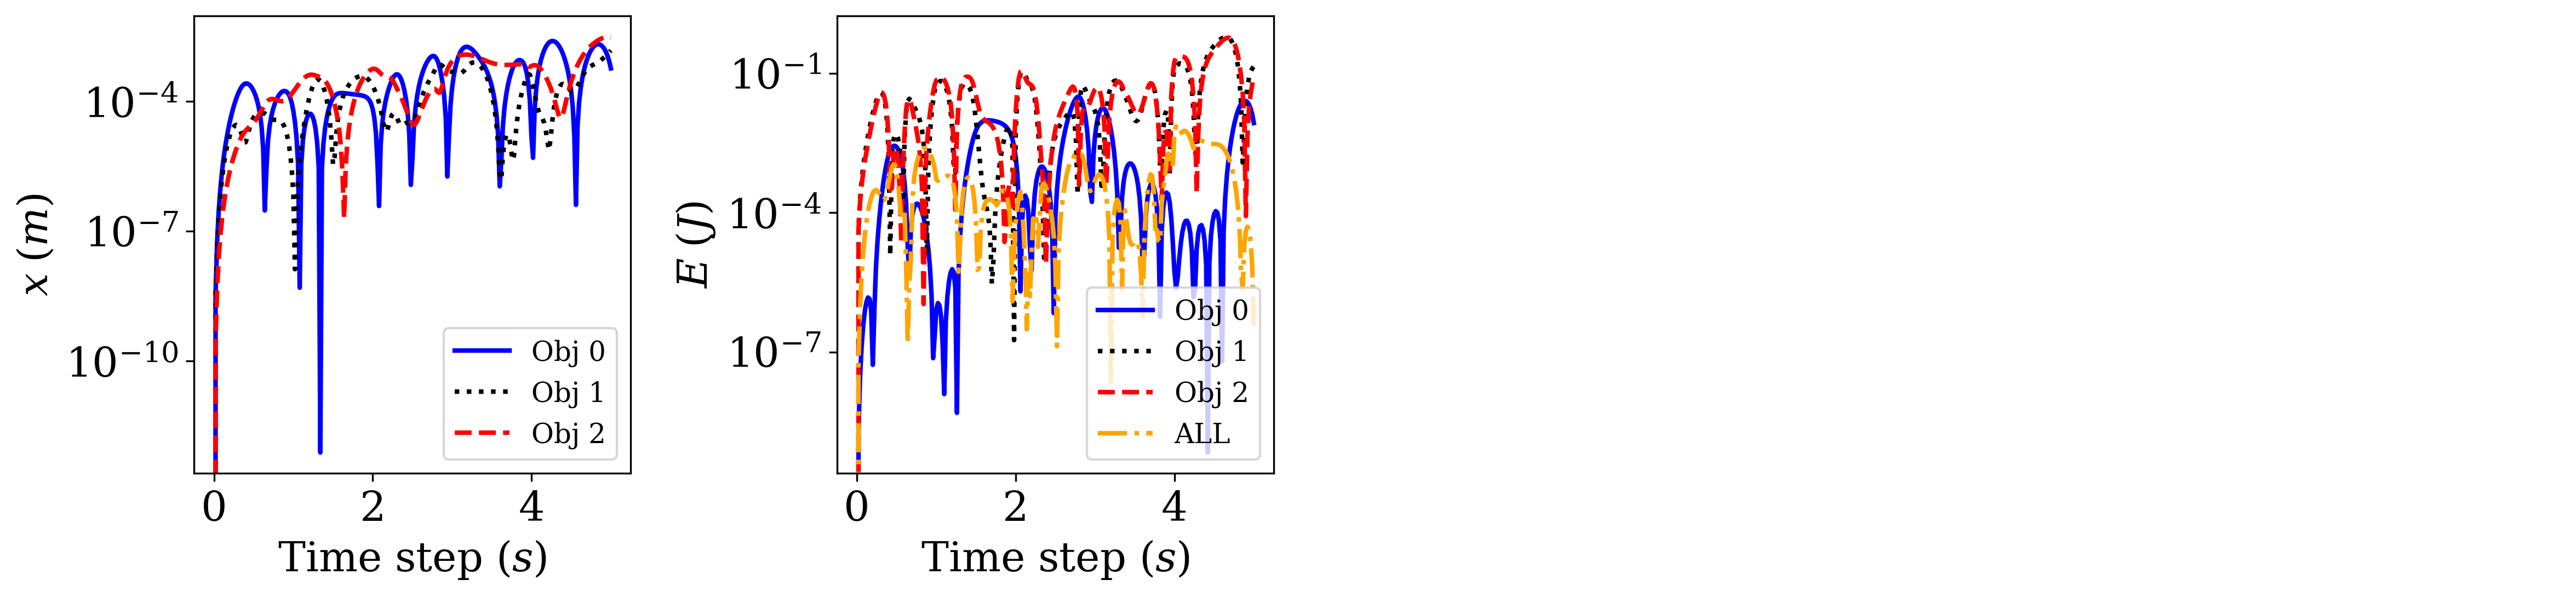

In [15]:
fig = plt.figure(figsize=[16,4], dpi=DPI)
tpad = 4
colors = ['b', 'k', 'r', 'orange', 'violet', 'lime']
lines  = ['solid', 'dotted', 'dashed', 'dashdot', (0, (3, 5, 1, 5, 1, 5)),
          (0, (1, 10)), (0, (5, 10)), (0, (3, 10, 1, 10)), 
           (0, (3, 10, 1, 10, 1, 10))] #'loosely dotted', 'loosely dashed', 'loosely dashdotted', 'dashdotdotted' and 'loosely dashdotdotted'

plt.subplot(1,4,1)
# plt.title("MSE between coordinates", pad=tpad) ; 
plt.xlabel('Time step ($s$)'); plt.ylabel('$x\;(m)$')
for i in range(args.obj):
    plt.semilogy(t_eval, ((truth_pos[:,2*i]-modlanet_pos[:,2*i])**2) + ((truth_pos[:,2*i+1]-modlanet_pos[:,2*i+1])**2), color = colors[i], linestyle = lines[i], label='Obj {}'.format(i), linewidth=2)
plt.legend(fontsize=12)
# plt.grid('on')

plt.subplot(1,4,2)
# plt.title("Total energy", pad=tpad)
plt.xlabel('Time step ($s$)'); plt.ylabel('$E\;(J)$')

j = 0
ds1 = Dataset(j+1, m = [1 for i in range(j+1)], l=[1 for i in range(j+1)])
true_e    = np.stack([ds1.lagrangian_fn(c[:j*2+2], eng=True) for c in truth_ivp['y'].T])
modlanet_e = np.stack([ds1.lagrangian_fn(c[:j*2+2], eng=True) for c in modlanet_ivp['y'].T])
plt.semilogy(t_eval, ((true_e) - (modlanet_e))**2,  color = colors[j], linestyle = lines[j], label='Obj {}'.format(j), linewidth=2)
true_e_old = true_e; modlanet_e_old = modlanet_e
for j in range(1, args.obj):
    ds1 = Dataset(j+1, m = [1 for i in range(j+1)], l=[1 for i in range(j+1)])
    true_e    = np.stack([ds1.lagrangian_fn(c[:j*2+2], eng=True) for c in truth_ivp['y'].T])
    modlanet_e = np.stack([ds1.lagrangian_fn(c[:j*2+2], eng=True) for c in modlanet_ivp['y'].T])
    plt.semilogy(t_eval, ((true_e-true_e_old) - (modlanet_e - modlanet_e_old))**2,  color = colors[j], linestyle = lines[j], label='Obj {}'.format(j),  linewidth=2)
    true_e_old = true_e; modlanet_e_old = modlanet_e
    
j = args.obj
true_e     = np.stack([ds.lagrangian_fn(c, eng=True) for c in truth_ivp['y'].T])
modlanet_e  = np.stack([ds.lagrangian_fn(c, eng=True) for c in modlanet_ivp['y'].T])
plt.semilogy(t_eval, (true_e - modlanet_e)**2,  color = colors[j], linestyle = lines[j], label='ALL',  linewidth=2)
# plt.plot(t_eval, true_e, 'k-', label='Ground truth', linewidth=2)
plt.legend(fontsize=12, loc='lower right')
# plt.grid('on')

ax = plt.subplot(1,4,3)
ax.axis('off')


ax = plt.subplot(1,4,4)
ax.axis('off')


plt.tight_layout()
fig.savefig('{}/pend-2+-integration-obj-{}-mse.{}'.format(args.result_dir, args.obj, FORMAT), bbox_inches="tight")


## Calculate bar error over 100 trajectoies

In [16]:
# Be careful! It will take a while.
# Uncomment the code below for checking.

print('Be careful to run it! It will take a while.')
"""
num_models = 3
start = 3
end = 5

# 3 models x 2 cases x 100 repeating times, each cell contains 100 trajectories (100 vectors).
x_list, e_list = [[[] for i in range(end-start)] for i in range(num_models)], \
    [[[] for i in range(end-start)] for i in range(num_models)]

# i: 100 repeating times
# j: 3 models
# k: 2 cases
for k in range(start, end):
    args.obj = k
    modlanet_model.update(obj = args.obj)
    modlanet_model_retrain = get_model(args, model_name = 'modlanet', load_obj = args.obj, hidden_dim = 50, end_epoch = 12000, noise = 0., learn_rate = 0.01)
    modlanet_model_retrain.update(obj = args.obj)
    
    for i in range(100):
        print(k, i)
        np.random.seed(i)
        ds = Dataset(args.obj, m= [1. for i in range(args.obj)], l= [1. for i in range(args.obj)])
        y0 = ds.random_config()
        timescale = 20
        end_time = 10
        t_span = [0, end_time]
        kwargs = {'t_eval': np.linspace(t_span[0], t_span[1], end_time*timescale+1), 'rtol': 1e-12}

        truth_ivp = ds.get_trajectory(t_span = t_span, y0=y0, timescale = timescale, system='modlanet')
        x, v, _, _, E = truth_ivp
        coords = np.concatenate([x.T, v.T], axis = 0)
        T, U = ds.lagrangian_kinetic(coords), ds.lagrangian_potential(coords)
        j = 0
        x_list[j][k-start].append(x.T)
        e_list[j][k-start].append(U+T)

        modlanet_ivp = integrate_model(args, modlanet_model, t_span, y0, model_name = 'modlanet', **kwargs)
        y = modlanet_ivp['y']
        x = modlanet_ivp['y'][:args.obj]
        T, U = ds.lagrangian_kinetic(y), ds.lagrangian_potential(y)
        j = 1
        x_list[j][k-start].append(x)
        e_list[j][k-start].append(U+T)
        
        modlanet_retrain_ivp = integrate_model(args, modlanet_model_retrain, t_span, y0, model_name = 'modlanet', **kwargs)
        y = modlanet_retrain_ivp['y']
        x = modlanet_retrain_ivp['y'][:args.obj]
        T, U = ds.lagrangian_kinetic(y), ds.lagrangian_potential(y)
        j = 2
        x_list[j][k-start].append(x)
        e_list[j][k-start].append(U+T)

np.save('{}/analysis-pend-2+.npy'.format(args.result_dir), {'x_list':np.array(x_list, dtype=object), 'e_list':np.array(e_list, dtype=object)})
"""

Be careful to run it! It will take a while.
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
3 10
3 11
3 12
3 13
3 14
3 15
3 16
3 17
3 18
3 19
3 20
3 21
3 22
3 23
3 24
3 25
3 26
3 27
3 28
3 29
3 30
3 31
3 32
3 33
3 34
3 35
3 36
3 37
3 38
3 39
3 40
3 41
3 42
3 43
3 44
3 45
3 46
3 47
3 48
3 49
3 50
3 51
3 52
3 53
3 54
3 55
3 56
3 57
3 58
3 59
3 60
3 61
3 62
3 63
3 64
3 65
3 66
3 67
3 68
3 69
3 70
3 71
3 72
3 73
3 74
3 75
3 76
3 77
3 78
3 79
3 80
3 81
3 82
3 83
3 84
3 85
3 86
3 87
3 88
3 89
3 90
3 91
3 92
3 93
3 94
3 95
3 96
3 97
3 98
3 99
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
4 10
4 11
4 12
4 13
4 14
4 15
4 16
4 17
4 18
4 19
4 20
4 21
4 22
4 23
4 24
4 25
4 26
4 27
4 28
4 29
4 30
4 31
4 32
4 33
4 34
4 35
4 36
4 37
4 38
4 39
4 40
4 41
4 42
4 43
4 44
4 45
4 46
4 47
4 48
4 49
4 50
4 51
4 52
4 53
4 54
4 55
4 56
4 57
4 58
4 59
4 60
4 61
4 62
4 63
4 64
4 65
4 66
4 67
4 68
4 69
4 70
4 71
4 72
4 73
4 74
4 75
4 76
4 77
4 78
4 79
4 80
4 81
4 82
4 83
4 84
4 85
4 86
4 87
4 88
4 89
4 90
4 91
4 92
4 93
4 94
4

In [17]:
results = np.load('{}/analysis-pend-2+.npy'.format(args.result_dir), allow_pickle=True).item()
x_list, e_list = results['x_list'], results['e_list']
timescale = 20
end_time = 10
t_span = [0, end_time]


In [20]:
num_models = 3
start = 3
end = 5

# 2 kinds of errors x 2 models x 2 cases x 100 errors
errors = np.zeros((2, num_models-1, end-start, 100), dtype = np.float32)

# 2 kinds of errors x 2 models x 2 cases
bar_data = np.zeros((2,2,3), dtype=np.float32)
bar_error = np.zeros((2,2,3), dtype=np.float32)

# The lengths of all trajectories are the same
length = len(e_list[0][0][0]) 

# i: 100 repeating times
# j: 2 models compared with the ground truth
# k: 3 cases
# m: 2 kinds of errors
for k in range(end-start):
    j = 0; m = 0
    print('Mean error and std of modlanet without retraining when simulating {}-pendulum system.'.format(k+start))
    for i in range(1):
        errors[m][j][k][i] = (np.linalg.norm(x_list[0][k][i]-x_list[1][k][i][:k+start])/length)
    bar_data[m][j][k] = np.mean(errors[m][j][k])
    bar_error[m][j][k] = np.std(errors[m][j][k])
    print('Mean error and std of position: {:.5f} +/- {:.5f}'.format(bar_data[m][j][k], bar_error[m][j][k]))

    j = 0; m = 1
    for i in range(1):
        errors[m][j][k][i] = (np.linalg.norm(e_list[0][k][i]-e_list[1][k][i])/length)
    bar_data[m][j][k] = np.mean(errors[m][j][k])
    bar_error[m][j][k] = np.std(errors[m][j][k])
    print('Mean error and std of total energy: {:.5f} +/- {:.5f}'.format(bar_data[m][j][k], bar_error[m][j][k]))

    print('')    
    
    j = 1; m = 0
    print('Mean error and std of modlanet after retraining when simulating {}-pendulum system.'.format(k+start))
    for i in range(1):
        errors[m][j][k][i] = (np.linalg.norm(x_list[0][k][i]-x_list[2][k][i][:k+start])/length)
    bar_data[m][j][k] = np.mean(errors[m][j][k])
    bar_error[m][j][k] = np.std(errors[m][j][k])
    print('Mean error and std of position: {:.5f} +/- {:.5f}'.format(bar_data[m][j][k], bar_error[m][j][k]))

    j = 1; m = 1
    for i in range(1):
        errors[m][j][k][i] = (np.linalg.norm(e_list[0][k][i]-e_list[2][k][i])/length)
    bar_data[m][j][k] = np.mean(errors[m][j][k])
    bar_error[m][j][k] = np.std(errors[m][j][k])
    print('Mean error and std of total energy: {:.5f} +/- {:.5f}'.format(bar_data[m][j][k], bar_error[m][j][k]))

    print('')

Mean error and std of modlanet without retraining when simulating 3-pendulum system.
Mean error and std of position: 0.00541 +/- 0.05382
Mean error and std of total energy: 0.01906 +/- 0.18969

Mean error and std of modlanet after retraining when simulating 3-pendulum system.
Mean error and std of position: 0.00236 +/- 0.02349
Mean error and std of total energy: 0.00065 +/- 0.00644

Mean error and std of modlanet without retraining when simulating 4-pendulum system.
Mean error and std of position: 0.01023 +/- 0.10179
Mean error and std of total energy: 0.06134 +/- 0.61037

Mean error and std of modlanet after retraining when simulating 4-pendulum system.
Mean error and std of position: 0.00029 +/- 0.00293
Mean error and std of total energy: 0.00259 +/- 0.02576



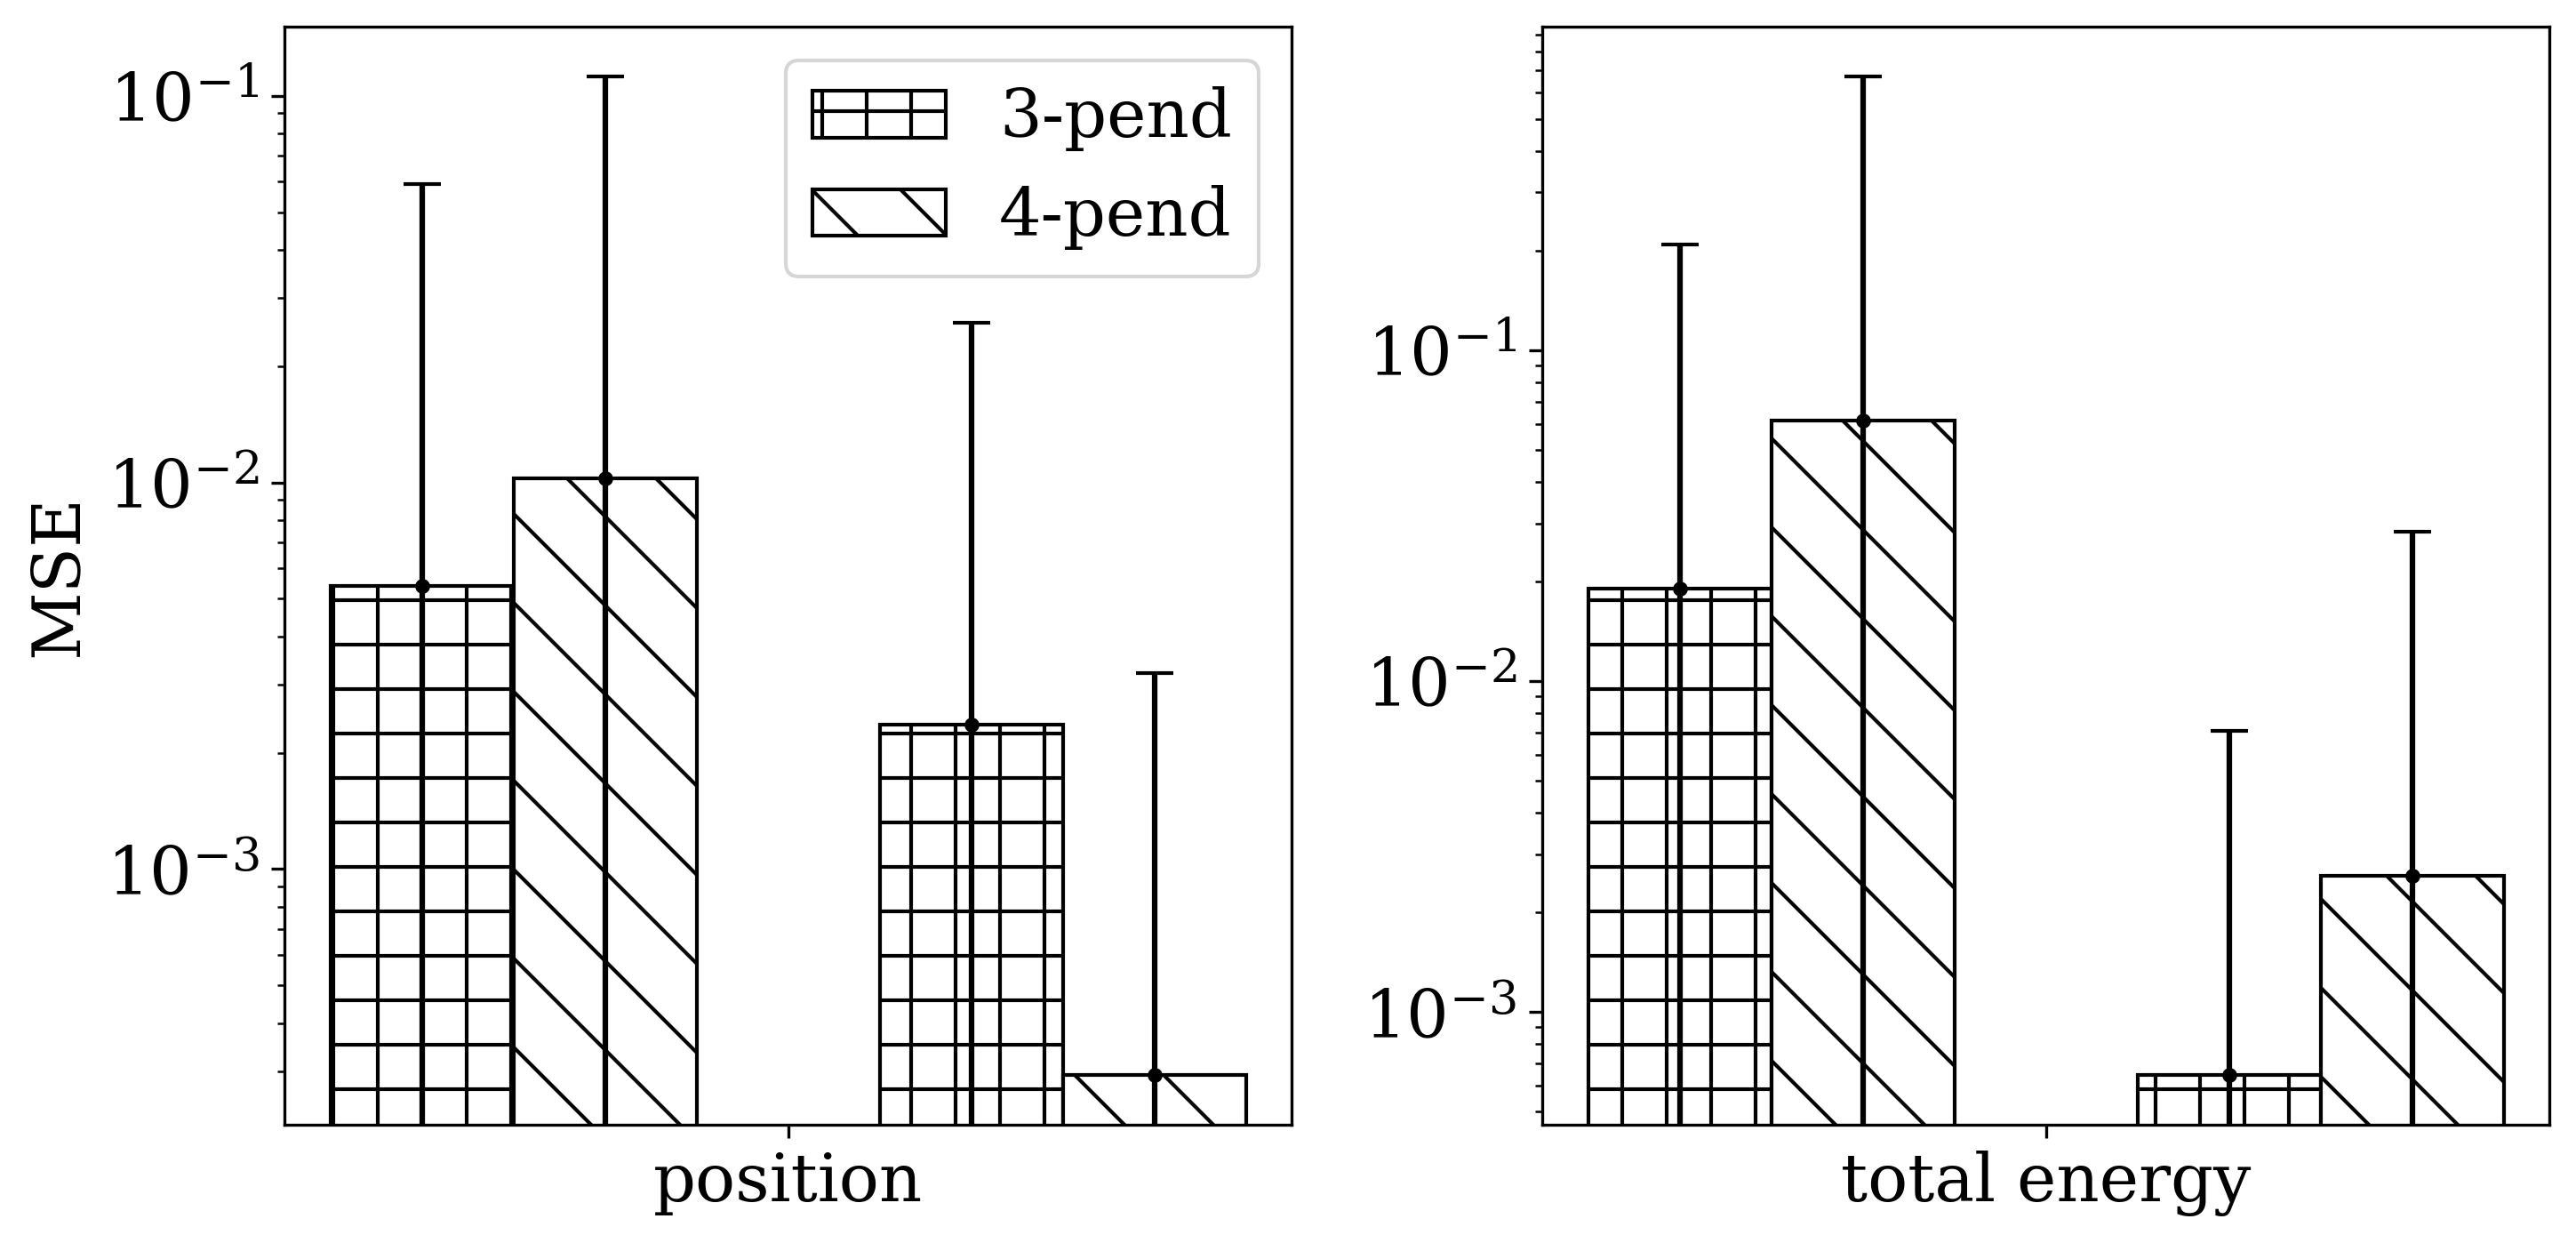

In [29]:
# Ref: 
# https://matplotlib.org/stable/gallery/scales/log_bar.html
# https://jakevdp.github.io/PythonDataScienceHandbook/04.03-errorbars.html

data_labels = ['{}-pend'.format(i) for i in range(3, 5)]

x_labels = [['position'], ['total energy'],]
y_labels = [['MSE']]
patterns = [ "+", "\\", "/", ".", "-", "|" ,"x", "*",  "o", "O" ]

x = np.arange(len(x_labels[0]))*1 # the label locations
width = 0.05 # the width of the bars

fig = plt.figure(figsize = [10, 5], dpi=DPI)
rects = []
for j in range(len(x_labels)):
    ax = plt.subplot(1, 2, j+1)
    for k in range(1):
        for i in range(0, len(data_labels)):
            rect = ax.bar(x - ((len(data_labels)-1)/2-i)*width - 1.5*width, bar_data[j:j+1, k, i], width, label=data_labels[i], color='white', edgecolor='black', hatch=patterns[i])
            rects.append(rect)
            plt.errorbar(x - ((len(data_labels)-1)/2-i)*width - 1.5*width, bar_data[j:j+1, k, i], yerr=bar_error[j:j+1, k, i], fmt='.k', capsize=5, capthick=1, label='__none__');
    for k in range(1, 2):
        for i in range(0, len(data_labels)):
            rect = ax.bar(x - ((len(data_labels)-1)/2-i)*width + 1.5*width, bar_data[j:j+1, k, i], width, label='__none__', color='white', edgecolor='black', hatch=patterns[i])
            rects.append(rect)
            plt.errorbar(x - ((len(data_labels)-1)/2-i)*width + 1.5*width, bar_data[j:j+1, k, i], yerr=bar_error[j:j+1, k, i], fmt='.k', capsize=5, capthick=1, label='__none__');
        
    # Add some text for labels, title and custom x-axis tick labels, etc.
    if j == 0:
        ax.legend(loc='upper right')
        ax.set_ylabel('MSE')
#         ax.set_ylim(bottom = 0)
        ax.set_yscale('log')
    if j == 1:
        ax.set_yscale('log')
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels[j])

fig.tight_layout()

plt.show()
fig.savefig('{}/pend-2+-100traj.png'.format(args.result_dir))
